In [166]:
import pandas as pd


final_dataset_loc = 'C:/Users/killi/KF_Repo/PGA_Golf/Python_Scripts/Rugby_Union/3. Clean Data/final_dataset_cleaned.csv'

final_dataset_df = pd.read_csv(final_dataset_loc)


# Filter for dates from January 1, 2024 for train data
# Try increase the amount of data - bring in World cup scores
train_data = final_dataset_df[final_dataset_df['date'] <=  '2024-10-06']

# Keep November internationals as Test data
test_data = final_dataset_df[(final_dataset_df['date'] > '2024-10-06')] 

# get lengths of datasets
# Removed World cup for now as not really a Home advantage
print(len(final_dataset_df))
print(len(train_data))
print(len(test_data))


158
119
39


In [167]:
# Identify teams to remove based on counts

import numpy as np

home_teams_unq = train_data['home_team'].unique()
away_teams_unq = train_data['away_team'].unique()

# Concatenate the arrays and keep unique values
unique_teams = np.unique(np.concatenate((home_teams_unq, away_teams_unq)))

# Sort the unique_teams list alphabetically
unique_teams_sorted = sorted(unique_teams)

# get number of teams
n_teams = len(unique_teams_sorted)
print(n_teams)

# Create the mapping (team name to index starting from 0)
team_mapping = {team: index for index, team in enumerate(unique_teams_sorted)}

# Print the mapping
print(team_mapping)

# Map the teams to numbers
train_data['home_num'] = train_data['home_team'].map(team_mapping)
train_data['away_num'] = train_data['away_team'].map(team_mapping)



27
{'Argentina': 0, 'Australia': 1, 'Belgium': 2, 'Brazil': 3, 'Canada': 4, 'Chile': 5, 'England': 6, 'Fiji': 7, 'France': 8, 'Georgia': 9, 'Hong Kong': 10, 'Ireland': 11, 'Italy': 12, 'Japan': 13, 'Namibia': 14, 'New Zealand': 15, 'Paraguay': 16, 'Portugal': 17, 'Romania': 18, 'Samoa': 19, 'Scotland': 20, 'South Africa': 21, 'Spain': 22, 'Tonga': 23, 'USA': 24, 'Uruguay': 25, 'Wales': 26}


C:\Users\killi\AppData\Local\Temp\ipykernel_13288\2606235992.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['home_num'] = train_data['home_team'].map(team_mapping)
C:\Users\killi\AppData\Local\Temp\ipykernel_13288\2606235992.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['away_num'] = train_data['away_team'].map(team_mapping)


In [168]:
# Map the teams to numbers
test_data['home_num'] = test_data['home_team'].map(team_mapping)
test_data['away_num'] = test_data['away_team'].map(team_mapping)

C:\Users\killi\AppData\Local\Temp\ipykernel_13288\961118146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['home_num'] = test_data['home_team'].map(team_mapping)
C:\Users\killi\AppData\Local\Temp\ipykernel_13288\961118146.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['away_num'] = test_data['away_team'].map(team_mapping)


In [169]:
# Take sample of 3 observations
test_data_sample = test_data.iloc[0:3]

# get home and away values from test set
home_team_test = test_data_sample['home_num'].values.astype(int)
away_team_test = test_data_sample['away_num'].values.astype(int)

import numpy as np


# This is final score data - won't be used by model
home_score_arr = train_data['home_score'].values
away_score_arr = train_data['away_score'].values

In [170]:
# Use Negative Binomial Model

import pymc as pm

# Create Model
with pm.Model() as nb_model:


    # Think this is the only shared data I need
    home_team_shared = pm.MutableData("home_team_shared",train_data['home_num'].values)
    away_team_shared = pm.MutableData("away_team_shared",train_data['away_num'].values)

    # Data used for Likelihoods in Model - all observed
    home_tries = train_data['Home_tries'].values
    away_tries = train_data['Away_tries'].values
    home_conv = train_data['Home_conv'].values
    away_conv = train_data['Away_conv'].values
    home_pg_dg = train_data['Home_pg_dg'].values
    away_pg_dg = train_data['Away_pg_dg'].values


    # Parameter for Home - Remove for now 
    #home_param_tries = pm.Normal("home_param_tries", 0, 0.5)
    #home_param_pg_dg = pm.Normal("home_param_pg_dg", 0, 0.5)

    # Attack ratings for teams - common mu and sd that all teams draw from
    atts_mu_tries = pm.Normal("atts_mu_tries", 0, 0.5)
    atts_sd_tries = pm.HalfNormal("atts_sd_tries", 0.5)
    atts_tries = pm.Normal("atts_tries", mu=atts_mu_tries, sigma=atts_sd_tries, shape=n_teams)

    # Defence ratings for teams - common mu and sd that all teams draw from
    defs_mu_tries = pm.Normal("defs_mu_tries", 0, 0.5)
    defs_sd_tries = pm.HalfNormal("defs_sd_tries", 0.5)
    defs_tries = pm.Normal("defs_tries", mu=defs_mu_tries, sigma=defs_sd_tries, shape=n_teams)

    # Attack ratings for teams - penalties
    atts_mu_pg_dg = pm.Normal("atts_mu_pg_dg", 0, 0.5)
    atts_sd_pg_dg = pm.HalfNormal("atts_sd_pg_dg", 0.5)
    atts_pg_dg = pm.Normal("atts_pg_dg", mu=atts_mu_pg_dg, sigma=atts_sd_pg_dg, shape=n_teams)

    # Defence ratings for teams - common mu and sd that all teams draw from
    defs_mu_pg_dg = pm.Normal("defs_mu_pg_dg", 0, 0.5)
    defs_sd_pg_dg = pm.HalfNormal("defs_sd_pg_dg", 0.5)
    defs_pg_dg = pm.Normal("defs_pg_dg", mu=defs_mu_pg_dg, sigma=defs_sd_pg_dg, shape=n_teams)


    # Create a parameter for kickers - wide priors
    kick_mu = pm.Normal("kick_mu", 0, 3)
    kick_sd = pm.HalfNormal("kick_sd", 3)
    kick = pm.Normal("kick", mu=kick_mu, sigma=kick_sd, shape=n_teams)
    
    # Calculate theta for tries

    # Register away_theta and home_theta as a deterministic variable
    # home_param_tries + 
    home_tries_theta = pm.Deterministic("home_tries_theta", pm.math.exp(
                                                                        atts_tries[home_team_shared] + 
                                                                        defs_tries[away_team_shared]))
    away_tries_theta = pm.Deterministic("away_tries_theta", pm.math.exp(atts_tries[away_team_shared] +
                                                                        defs_tries[home_team_shared]))

    # Create alpha - Gamma shape parameter
    alpha_home_tries = pm.HalfNormal("alpha_home_tries",2)
    alpha_away_tries = pm.HalfNormal("alpha_away_tries",2)

    # Negative Binomial for tries
    home_tries_nb = pm.NegativeBinomial("home_tries_nb",mu=home_tries_theta, 
                                      alpha=alpha_home_tries, 
                                        observed=home_tries,
                                        shape = home_tries_theta.shape)
    away_tries_nb = pm.NegativeBinomial("away_tries_nb",
                                        mu=away_tries_theta, 
                                     alpha=alpha_away_tries,
                                        observed=away_tries,
                                       shape = away_tries_theta.shape)


    # Get p for home conv and away
    # This should only depend on the kicker for that team - removed home advantage
    p_home_conv = pm.Deterministic("p_home_conv", pm.math.invlogit(kick[home_team_shared] ))
    p_away_conv = pm.Deterministic("p_away_conv", pm.math.invlogit(kick[away_team_shared] ) )

    # Estimating p_home_conv and p_away_conv here - have data for n and observed
    # Changed N to home_tries_nb from home_tries
    home_conv_bin =  pm.Binomial("home_conv_bin",
                                 n=home_tries_nb, 
                                 p=p_home_conv, 
                                 observed= home_conv,
                                shape = p_home_conv.shape)
    away_conv_bin =  pm.Binomial("away_conv_bin",
                                 n=away_tries_nb, 
                                 p=p_away_conv, 
                                 observed= away_conv,
                                shape = p_away_conv.shape)

    # Calculate theta for penalties and drop goals

    # Register away_theta and home_theta as a deterministic variable
    # home_param_pg_dg
    home_pg_dg_theta = pm.Deterministic("home_pg_dg_theta", pm.math.exp(
                                                                        atts_pg_dg[home_team_shared]
                                                                        + defs_pg_dg[away_team_shared]))
    
    away_pg_dg_theta = pm.Deterministic("away_pg_dg_theta", pm.math.exp(atts_pg_dg[away_team_shared]
                                                                        + defs_pg_dg[home_team_shared]))

    # Create alpha - Gamma shape parameter for penalties
    alpha_home_pg_dg = pm.HalfNormal("alpha_home_pg_dg",2)
    alpha_away_pg_dg = pm.HalfNormal("alpha_away_pg_dg",2)

    # Negative Binomial for tries
    # alpha is the over dispersion parameter
    # When alpha is large - variance equals mean
    # smaller values lead to greater over dispersion
    # var = mu + (mu2/ alpha) - 4.7 here some over dispersion
    home_pg_dg_nb = pm.NegativeBinomial("home_pg_dg_nb",mu=home_pg_dg_theta, 
                                      alpha=alpha_home_pg_dg, 
                                        observed=home_pg_dg,
                                       shape = home_pg_dg_theta.shape)
    away_pg_dg_nb = pm.NegativeBinomial("away_pg_dg_nb",mu=away_pg_dg_theta, 
                                     alpha=alpha_away_pg_dg,
                                        observed=away_pg_dg,
                                       shape = away_pg_dg_theta.shape)

    # Get prior samples
    prior_samples = pm.sample_prior_predictive(100)

# Create Model
with nb_model:
    trace = pm.sample(1000, tune=2000, cores=4, return_inferencedata=True)


# Define home_score_model and away_score_model in posterior predictive step
with nb_model:
    home_score_model = pm.Deterministic("home_score_model", home_tries_nb * 5 + home_conv_bin * 2 + home_pg_dg_nb * 3)
    away_score_model = pm.Deterministic("away_score_model", away_tries_nb * 5 + away_conv_bin * 2 + away_pg_dg_nb * 3)
    
    # Sample from posterior predictive
    posterior_predictive_samples = pm.sample_posterior_predictive(trace,extend_inferencedata=True)


Sampling: [alpha_away_pg_dg, alpha_away_tries, alpha_home_pg_dg, alpha_home_tries, atts_mu_pg_dg, atts_mu_tries, atts_pg_dg, atts_sd_pg_dg, atts_sd_tries, atts_tries, away_conv_bin, away_pg_dg_nb, away_tries_nb, defs_mu_pg_dg, defs_mu_tries, defs_pg_dg, defs_sd_pg_dg, defs_sd_tries, defs_tries, home_conv_bin, home_pg_dg_nb, home_tries_nb, kick, kick_mu, kick_sd]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [atts_mu_tries, atts_sd_tries, atts_tries, defs_mu_tries, defs_sd_tries, defs_tries, atts_mu_pg_dg, atts_sd_pg_dg, atts_pg_dg, defs_mu_pg_dg, defs_sd_pg_dg, defs_pg_dg, kick_mu, kick_sd, kick, alpha_home_tries, alpha_away_tries, alpha_home_pg_dg, alpha_away_pg_dg]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 308 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 439 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [away_conv_bin, away_pg_dg_nb, away_tries_nb, home_conv_bin, home_pg_dg_nb, home_tries_nb]


In [171]:
# Think I need to use shared variables

with nb_model:
     pm.set_data({"home_team_shared": home_team_test, "away_team_shared": away_team_test})
     ppc_test = pm.sample_posterior_predictive(trace)
     ppc_test_home_score = ppc_test.posterior_predictive.home_score_model.stack(sample=("chain", "draw"))
     ppc_test_away_score = ppc_test.posterior_predictive.away_score_model.stack(sample=("chain", "draw"))



Sampling: [away_conv_bin, away_pg_dg_nb, away_tries_nb, home_conv_bin, home_pg_dg_nb, home_tries_nb]


In [172]:
# Get summary of trace
# Priors seem to be quite strong
# Hong Kong is still very high attacking based on 2 results
# It does get pulled toward the group mean however here
# Hong kong still looks high - this is because it wasn't in the world cup
# It has a higher attacking strength than England which doesn't make sense

import arviz as az

# Generate the summary of the posterior
summary_df = az.summary(trace.posterior, round_to=2)

# filter for columns
summary_df = summary_df[['mean','sd','hdi_3%','hdi_97%','r_hat']]

# Add in teams
def replace_index_with_team_name(index, mapping):
    # Match patterns like "atts[0]" or "defs[0]" and replace "0" with the team name
    if index.startswith("atts_tries[") or index.startswith("defs_tries[") or index.startswith("kick[") or index.startswith("atts_pg_dg[") or index.startswith("defs_pg_dg["):
        # Extract the parameter type (e.g., "atts" or "defs") and the team index
        param_type = index.split("[")[0]
        team_index = int(index.split("[")[1].strip("]"))  # Extract the number inside brackets
        
        # Find the corresponding team name from the mapping
        for team, num in mapping.items():
            if num == team_index:
                return f"{param_type}[{team}]"
    return index  # Leave other rows unchanged

summary_df = summary_df.rename(index=lambda x: replace_index_with_team_name(x, team_mapping))

# Save as csv
summary_df.to_csv('summary_df_nb.csv')

# Set display options
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Display the updated DataFrame
print(summary_df)

                           mean    sd  hdi_3%  hdi_97%  r_hat
atts_mu_tries              0.55  0.32   -0.01     1.17   1.04
atts_tries[Argentina]      0.80  0.35    0.18     1.48   1.02
atts_tries[Australia]      0.63  0.36   -0.03     1.30   1.02
atts_tries[Belgium]        0.55  0.42   -0.25     1.31   1.02
atts_tries[Brazil]         0.46  0.41   -0.33     1.21   1.02
atts_tries[Canada]         0.37  0.41   -0.36     1.14   1.03
atts_tries[Chile]          0.29  0.41   -0.47     1.03   1.02
atts_tries[England]        0.64  0.36   -0.04     1.30   1.03
atts_tries[Fiji]           0.62  0.36   -0.04     1.30   1.02
atts_tries[France]         0.83  0.36    0.17     1.51   1.02
atts_tries[Georgia]        0.35  0.40   -0.43     1.03   1.03
atts_tries[Hong Kong]      0.77  0.41   -0.08     1.50   1.02
atts_tries[Ireland]        0.93  0.37    0.20     1.57   1.03
atts_tries[Italy]          0.57  0.36   -0.13     1.21   1.02
atts_tries[Japan]          0.67  0.36    0.05     1.42   1.02
atts_tri

In [173]:
# Look at train data for New Zealand
# New Zealand played strong teams apart from Fiji
train_data[(train_data['home_team'] == 'New Zealand') | (train_data['away_team'] == 'New Zealand') ]


,date,home_team,away_team,home_score,away_score,Home_tries,Away_tries,Home_conv,Away_conv,Home_conv_att,Away_conv_att,Home_pg,Away_pg,Home_pg_att,Away_pg_att,Home_dg,Away_dg,Home_dg_att,Away_dg_att,Home_pg_dg,Away_pg_dg,home_num,away_num
0,2023-09-08,France,New Zealand,27,13,2.0,2.0,1.0,0.0,2.0,2.0,5.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,8,15
9,2023-09-15,New Zealand,Namibia,71,3,11.0,0.0,8.0,0.0,11.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,15,14
26,2023-09-29,New Zealand,Italy,96,17,14.0,2.0,13.0,2.0,14.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,15,12
32,2023-10-05,New Zealand,Uruguay,73,0,11.0,0.0,9.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,25
41,2023-10-14,Ireland,New Zealand,24,28,3.0,3.0,3.0,2.0,2.0,3.0,1.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,3.0,11,15
44,2023-10-20,Argentina,New Zealand,6,44,0.0,7.0,0.0,3.0,0.0,7.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0,15
47,2023-10-28,New Zealand,South Africa,11,12,1.0,0.0,0.0,0.0,1.0,0.0,2.0,4.0,3.0,4.0,0.0,0.0,0.0,0.0,2.0,4.0,15,21
70,2024-07-06,New Zealand,England,16,15,2.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,15,6
81,2024-07-13,New Zealand,England,24,17,2.0,2.0,1.0,2.0,2.0,2.0,4.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,15,6
91,2024-07-20,New Zealand,Fiji,47,5,7.0,1.0,6.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,7


In [174]:
# Look at Japan data
# Japan only played England who were hard and scored 17
# Would expect a similar score vs New Zealand
train_data[(train_data['home_team'] == 'Japan') | (train_data['away_team'] == 'Japan') ]

,date,home_team,away_team,home_score,away_score,Home_tries,Away_tries,Home_conv,Away_conv,Home_conv_att,Away_conv_att,Home_pg,Away_pg,Home_pg_att,Away_pg_att,Home_dg,Away_dg,Home_dg_att,Away_dg_att,Home_pg_dg,Away_pg_dg,home_num,away_num
6,2023-09-10,Japan,Chile,42,12,6.0,2.0,6.0,1.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,5
14,2023-09-17,England,Japan,34,12,4.0,0.0,4.0,0.0,4.0,0.0,2.0,4.0,3.0,4.0,0.0,0.0,0.0,0.0,2.0,4.0,6,13
25,2023-09-28,Japan,Samoa,28,22,3.0,3.0,2.0,2.0,3.0,3.0,3.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0,13,19
38,2023-10-08,Japan,Argentina,27,39,3.0,5.0,3.0,4.0,3.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,2.0,13,0
64,2024-06-22,Japan,England,17,52,2.0,8.0,2.0,6.0,2.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13,6
79,2024-07-13,Japan,Georgia,23,25,2.0,3.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0,2.0,0.0,0.0,0.0,0.0,3.0,2.0,13,9
92,2024-07-21,Japan,Italy,14,42,2.0,5.0,2.0,4.0,2.0,4.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,13,12
100,2024-08-25,Canada,Japan,28,55,4.0,8.0,4.0,6.0,4.0,6.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4,13
106,2024-09-07,Japan,USA,41,24,5.0,3.0,5.0,3.0,5.0,3.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,13,24
111,2024-09-15,Samoa,Japan,27,49,3.0,7.0,3.0,7.0,3.0,6.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,19,13


In [175]:
# Now try look at parameters estimated
# Need to look at posterior - atts tries should be expected tries for team
atts_tries_sim = posterior_predictive_samples.posterior.atts_tries.stack(sample=("chain", "draw")).values
# Also get defs tries
defs_tries_sim = posterior_predictive_samples.posterior.defs_tries.stack(sample=("chain", "draw")).values


In [176]:
# Print the mapping
print(team_mapping)

{'Argentina': 0, 'Australia': 1, 'Belgium': 2, 'Brazil': 3, 'Canada': 4, 'Chile': 5, 'England': 6, 'Fiji': 7, 'France': 8, 'Georgia': 9, 'Hong Kong': 10, 'Ireland': 11, 'Italy': 12, 'Japan': 13, 'Namibia': 14, 'New Zealand': 15, 'Paraguay': 16, 'Portugal': 17, 'Romania': 18, 'Samoa': 19, 'Scotland': 20, 'South Africa': 21, 'Spain': 22, 'Tonga': 23, 'USA': 24, 'Uruguay': 25, 'Wales': 26}


In [177]:
# Get array for atts New Zealand
np.mean(atts_tries_sim[15])

1.0901635483455792

In [ ]:
# When theta is calculated Home and attacking strength and defensive strength added
# This is used to calculate Home theta
# As these parameters are multiplied by each other - increases rate by 5%
# Only increased try scoring rate from 1.82 to 1.91 - think I should remove home advantage

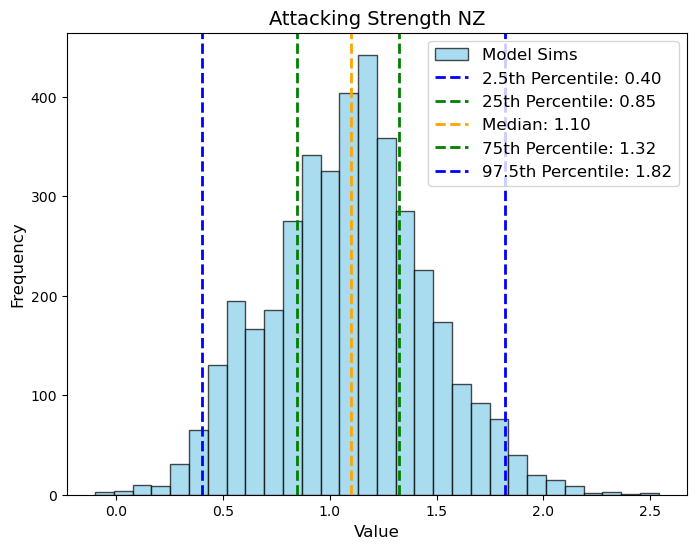

In [178]:
import matplotlib.pyplot as plt
import numpy as np

# run a loop to run through scores
i = 15

# set data
sim_data = atts_tries_sim[i]

# Calculate 95% percentiles
lower_percentile = np.percentile(sim_data, 2.5)
upper_percentile = np.percentile(sim_data, 97.5)
lower_25 = np.percentile(sim_data, 25)
upper_75 = np.percentile(sim_data, 75)
median = np.percentile(sim_data, 50)


# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(sim_data, bins=30, color='skyblue',
         alpha=0.7, edgecolor='black', label='Model Sims')

# Add vertical lines for the percentiles
plt.axvline(lower_percentile, color='blue', linestyle='--', linewidth=2, label=f'2.5th Percentile: {lower_percentile:.2f}')
plt.axvline(lower_25, color='green', linestyle='--', linewidth=2, label=f'25th Percentile: {lower_25:.2f}')
plt.axvline(median, color='orange', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
plt.axvline(upper_75, color='green', linestyle='--', linewidth=2, label=f'75th Percentile: {upper_75:.2f}')
plt.axvline(upper_percentile, color='blue', linestyle='--', linewidth=2, label=f'97.5th Percentile: {upper_percentile:.2f}')


# Add labels, title, and legend
plt.title('Attacking Strength NZ', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)

# Show the plot
plt.show()


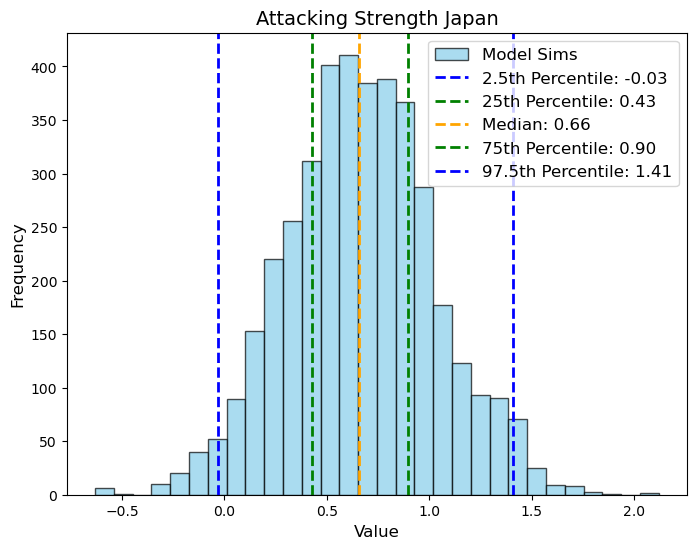

In [179]:
import matplotlib.pyplot as plt
import numpy as np

# run a loop to run through scores
i = 13

# set data
sim_data = atts_tries_sim[i]

# Calculate 95% percentiles
lower_percentile = np.percentile(sim_data, 2.5)
upper_percentile = np.percentile(sim_data, 97.5)
lower_25 = np.percentile(sim_data, 25)
upper_75 = np.percentile(sim_data, 75)
median = np.percentile(sim_data, 50)


# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(sim_data, bins=30, color='skyblue',
         alpha=0.7, edgecolor='black', label='Model Sims')

# Add vertical lines for the percentiles
plt.axvline(lower_percentile, color='blue', linestyle='--', linewidth=2, label=f'2.5th Percentile: {lower_percentile:.2f}')
plt.axvline(lower_25, color='green', linestyle='--', linewidth=2, label=f'25th Percentile: {lower_25:.2f}')
plt.axvline(median, color='orange', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
plt.axvline(upper_75, color='green', linestyle='--', linewidth=2, label=f'75th Percentile: {upper_75:.2f}')
plt.axvline(upper_percentile, color='blue', linestyle='--', linewidth=2, label=f'97.5th Percentile: {upper_percentile:.2f}')


# Add labels, title, and legend
plt.title('Attacking Strength Japan', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)

# Show the plot
plt.show()


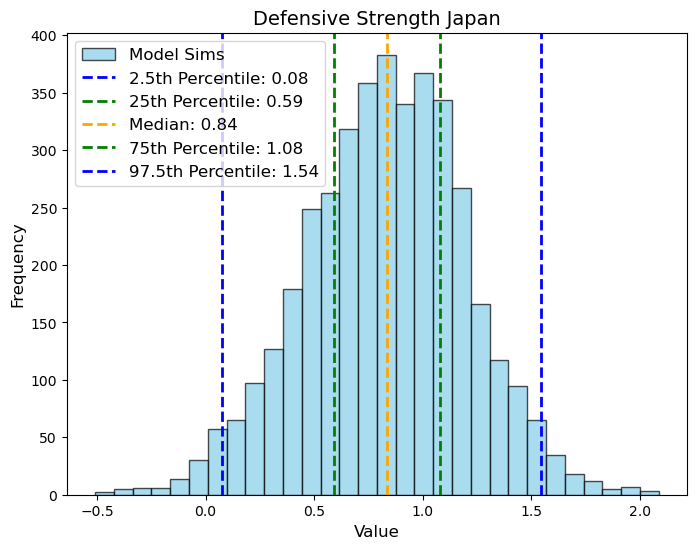

In [180]:
import matplotlib.pyplot as plt
import numpy as np

# run a loop to run through scores
i = 13

# set data
sim_data = defs_tries_sim[i]

# Calculate 95% percentiles
lower_percentile = np.percentile(sim_data, 2.5)
upper_percentile = np.percentile(sim_data, 97.5)
lower_25 = np.percentile(sim_data, 25)
upper_75 = np.percentile(sim_data, 75)
median = np.percentile(sim_data, 50)


# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(sim_data, bins=30, color='skyblue',
         alpha=0.7, edgecolor='black', label='Model Sims')

# Add vertical lines for the percentiles
plt.axvline(lower_percentile, color='blue', linestyle='--', linewidth=2, label=f'2.5th Percentile: {lower_percentile:.2f}')
plt.axvline(lower_25, color='green', linestyle='--', linewidth=2, label=f'25th Percentile: {lower_25:.2f}')
plt.axvline(median, color='orange', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
plt.axvline(upper_75, color='green', linestyle='--', linewidth=2, label=f'75th Percentile: {upper_75:.2f}')
plt.axvline(upper_percentile, color='blue', linestyle='--', linewidth=2, label=f'97.5th Percentile: {upper_percentile:.2f}')


# Add labels, title, and legend
plt.title('Defensive Strength Japan', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)

# Show the plot
plt.show()


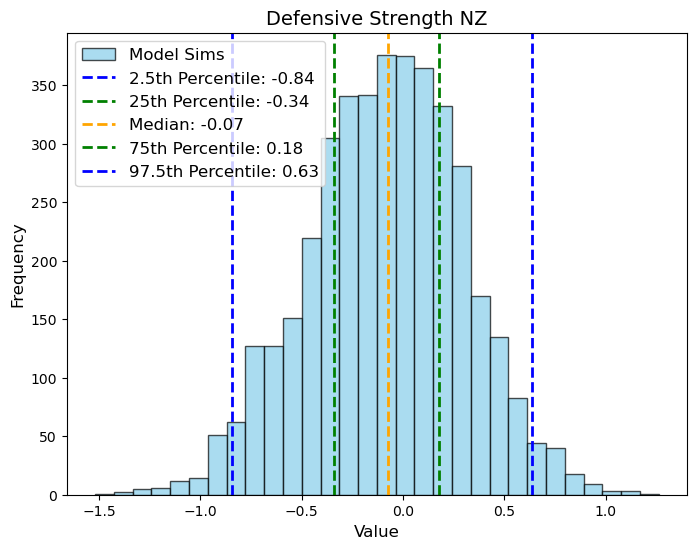

In [181]:
import matplotlib.pyplot as plt
import numpy as np

# run a loop to run through scores
i = 15

# set data
sim_data = defs_tries_sim[i]

# Calculate 95% percentiles
lower_percentile = np.percentile(sim_data, 2.5)
upper_percentile = np.percentile(sim_data, 97.5)
lower_25 = np.percentile(sim_data, 25)
upper_75 = np.percentile(sim_data, 75)
median = np.percentile(sim_data, 50)


# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(sim_data, bins=30, color='skyblue',
         alpha=0.7, edgecolor='black', label='Model Sims')

# Add vertical lines for the percentiles
plt.axvline(lower_percentile, color='blue', linestyle='--', linewidth=2, label=f'2.5th Percentile: {lower_percentile:.2f}')
plt.axvline(lower_25, color='green', linestyle='--', linewidth=2, label=f'25th Percentile: {lower_25:.2f}')
plt.axvline(median, color='orange', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
plt.axvline(upper_75, color='green', linestyle='--', linewidth=2, label=f'75th Percentile: {upper_75:.2f}')
plt.axvline(upper_percentile, color='blue', linestyle='--', linewidth=2, label=f'97.5th Percentile: {upper_percentile:.2f}')


# Add labels, title, and legend
plt.title('Defensive Strength NZ', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)

# Show the plot
plt.show()


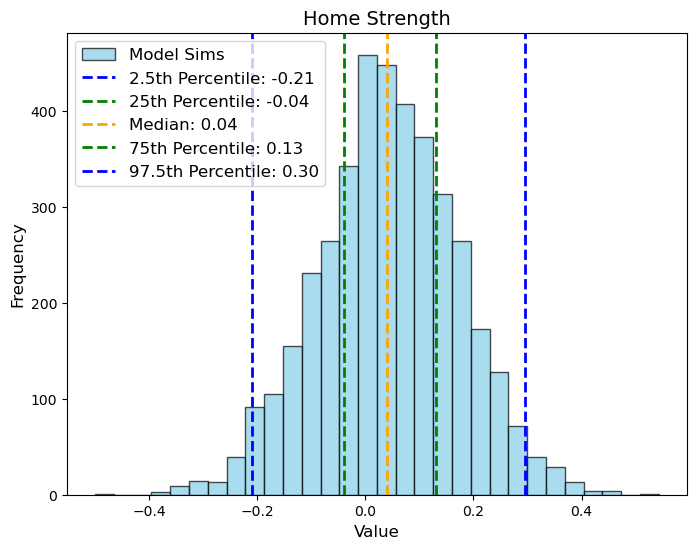

In [134]:
import matplotlib.pyplot as plt
import numpy as np



# set data
sim_data = home_tries_sim

# Calculate 95% percentiles
lower_percentile = np.percentile(sim_data, 2.5)
upper_percentile = np.percentile(sim_data, 97.5)
lower_25 = np.percentile(sim_data, 25)
upper_75 = np.percentile(sim_data, 75)
median = np.percentile(sim_data, 50)


# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(sim_data, bins=30, color='skyblue',
         alpha=0.7, edgecolor='black', label='Model Sims')

# Add vertical lines for the percentiles
plt.axvline(lower_percentile, color='blue', linestyle='--', linewidth=2, label=f'2.5th Percentile: {lower_percentile:.2f}')
plt.axvline(lower_25, color='green', linestyle='--', linewidth=2, label=f'25th Percentile: {lower_25:.2f}')
plt.axvline(median, color='orange', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
plt.axvline(upper_75, color='green', linestyle='--', linewidth=2, label=f'75th Percentile: {upper_75:.2f}')
plt.axvline(upper_percentile, color='blue', linestyle='--', linewidth=2, label=f'97.5th Percentile: {upper_percentile:.2f}')


# Add labels, title, and legend
plt.title('Home Strength', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)

# Show the plot
plt.show()


In [135]:
test_data_sample

,date,home_team,away_team,home_score,away_score,Home_tries,Away_tries,Home_conv,Away_conv,Home_conv_att,Away_conv_att,Home_pg,Away_pg,Home_pg_att,Away_pg_att,Home_dg,Away_dg,Home_dg_att,Away_dg_att,Home_pg_dg,Away_pg_dg,home_num,away_num
119,2024-10-26,Japan,New Zealand,19,64,3.0,10.0,2.0,7.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,15.0
120,2024-11-02,England,New Zealand,22,24,1.0,3.0,1.0,3.0,1.0,3.0,5.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,6.0,15.0
121,2024-11-02,Scotland,Fiji,57,17,8.0,3.0,7.0,1.0,8.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.0,7.0


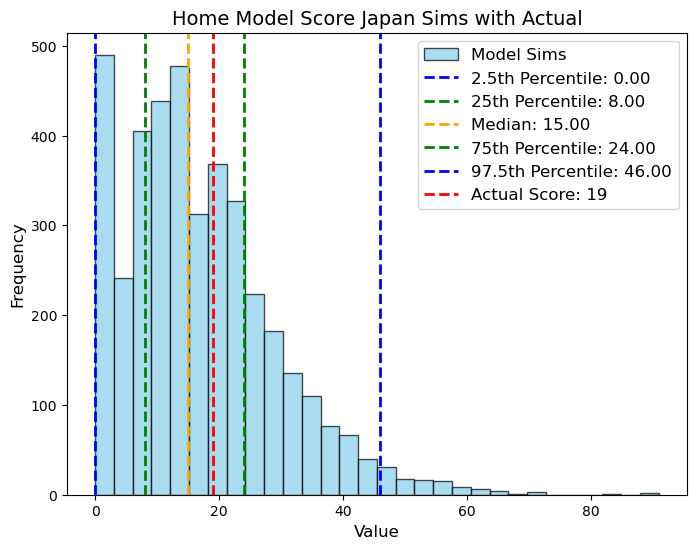

In [182]:
import matplotlib.pyplot as plt
import numpy as np

# run a loop to run through scores
i = 0


# Calculate 95% percentiles
lower_percentile = np.percentile(ppc_test_home_score[i].values, 2.5)
upper_percentile = np.percentile(ppc_test_home_score[i].values, 97.5)
lower_25 = np.percentile(ppc_test_home_score[i].values, 25)
upper_75 = np.percentile(ppc_test_home_score[i].values, 75)
median = np.percentile(ppc_test_home_score[i].values, 50)


# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(ppc_test_home_score[i].values, bins=30, color='skyblue',
         alpha=0.7, edgecolor='black', label='Model Sims')

# Add vertical lines for the percentiles
plt.axvline(lower_percentile, color='blue', linestyle='--', linewidth=2, label=f'2.5th Percentile: {lower_percentile:.2f}')
plt.axvline(lower_25, color='green', linestyle='--', linewidth=2, label=f'25th Percentile: {lower_25:.2f}')
plt.axvline(median, color='orange', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
plt.axvline(upper_75, color='green', linestyle='--', linewidth=2, label=f'75th Percentile: {upper_75:.2f}')
plt.axvline(upper_percentile, color='blue', linestyle='--', linewidth=2, label=f'97.5th Percentile: {upper_percentile:.2f}')


# Add a vertical line
plt.axvline(test_data_sample.home_score.iloc[i], color='red', linestyle='--', linewidth=2, 
            label=f'Actual Score: {test_data_sample.home_score.iloc[i]}')

# Add labels, title, and legend
plt.title('Home Model Score Japan Sims with Actual', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)

# Show the plot
plt.show()


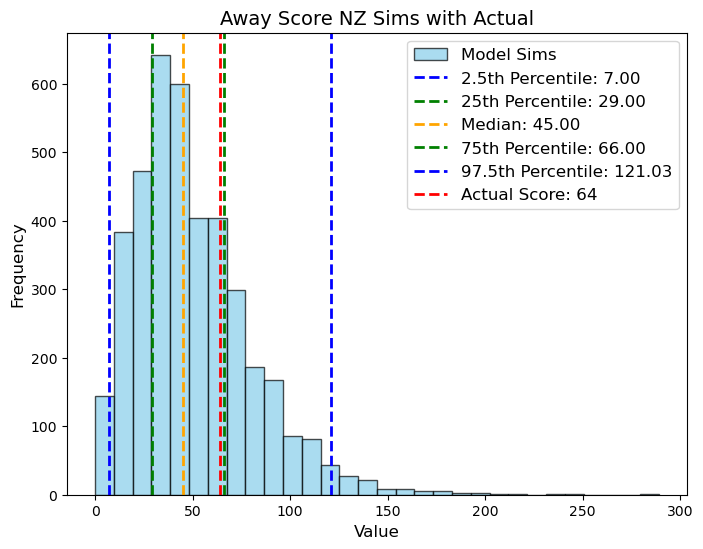

In [183]:
import matplotlib.pyplot as plt
import numpy as np

# run a loop to run through scores
i = 0


# Calculate 95% percentiles
lower_percentile = np.percentile(ppc_test_away_score[i].values, 2.5)
upper_percentile = np.percentile(ppc_test_away_score[i].values, 97.5)
lower_25 = np.percentile(ppc_test_away_score[i].values, 25)
upper_75 = np.percentile(ppc_test_away_score[i].values, 75)
median = np.percentile(ppc_test_away_score[i].values, 50)


# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(ppc_test_away_score[i].values, bins=30, color='skyblue',
         alpha=0.7, edgecolor='black', label='Model Sims')

# Add vertical lines for the percentiles
plt.axvline(lower_percentile, color='blue', linestyle='--', linewidth=2, label=f'2.5th Percentile: {lower_percentile:.2f}')
plt.axvline(lower_25, color='green', linestyle='--', linewidth=2, label=f'25th Percentile: {lower_25:.2f}')
plt.axvline(median, color='orange', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
plt.axvline(upper_75, color='green', linestyle='--', linewidth=2, label=f'75th Percentile: {upper_75:.2f}')
plt.axvline(upper_percentile, color='blue', linestyle='--', linewidth=2, label=f'97.5th Percentile: {upper_percentile:.2f}')


# Add a vertical line
plt.axvline(test_data_sample.away_score.iloc[i], color='red', linestyle='--', linewidth=2, 
            label=f'Actual Score: {test_data_sample.away_score.iloc[i]}')

# Add labels, title, and legend
plt.title('Away Score NZ Sims with Actual', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)

# Show the plot
plt.show()


In [ ]:
# Median for Japan was 21
# Median for NZ was 28
# This is implied that the spread would be 7
# And that the over under would be 49
# Final score was 64-19
# NZ scored 10 tries to Japans 3
# Over under was 66.5, and spread was + 33
# This implies a score of 50 to 17
# So my median score is way off
# If we ignore penalties and assume all nz scores come from tries
# Actual conversion rate was 70% - lets assume 80%
# 8 tries is 56 points, 50 points would be 62% conversion
# 9 tries would be 63, if 7 converted that would be 59
# Best estimate is they probably expected 8 tries, whereas my median is 3
# Something must be off with my estimates - maybe its shrinkage 
# check nz previous tries from the data


In [184]:
home_tries_sim = ppc_test.posterior_predictive.home_tries_nb.stack(sample=("chain", "draw"))
away_tries_sim = ppc_test.posterior_predictive.away_tries_nb.stack(sample=("chain", "draw"))

# get sims for penalties and drop goals
home_pg_dg_sim = ppc_test.posterior_predictive.home_pg_dg_nb.stack(sample=("chain", "draw"))
away_pg_dg_sim = ppc_test.posterior_predictive.away_pg_dg_nb.stack(sample=("chain", "draw"))

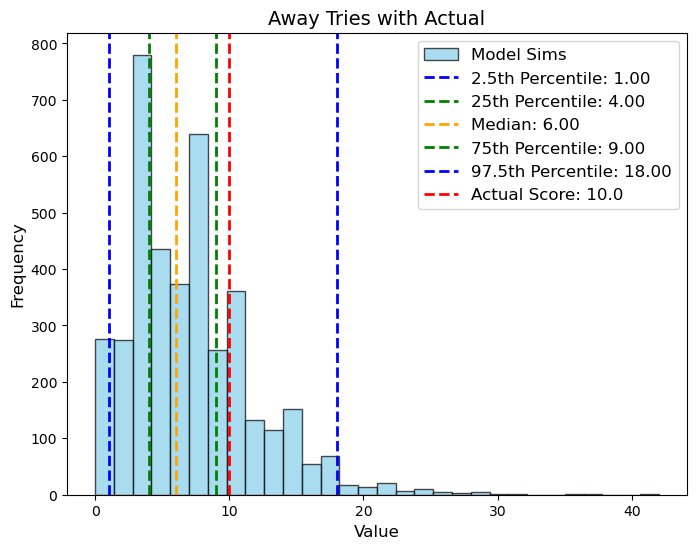

In [185]:
import matplotlib.pyplot as plt
import numpy as np

# run a loop to run through scores
i = 0

# set data
sim_data = away_tries_sim[i].values

# Calculate 95% percentiles
lower_percentile = np.percentile(sim_data, 2.5)
upper_percentile = np.percentile(sim_data, 97.5)
lower_25 = np.percentile(sim_data, 25)
upper_75 = np.percentile(sim_data, 75)
median = np.percentile(sim_data, 50)


# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(sim_data, bins=30, color='skyblue',
         alpha=0.7, edgecolor='black', label='Model Sims')

# Add vertical lines for the percentiles
plt.axvline(lower_percentile, color='blue', linestyle='--', linewidth=2, label=f'2.5th Percentile: {lower_percentile:.2f}')
plt.axvline(lower_25, color='green', linestyle='--', linewidth=2, label=f'25th Percentile: {lower_25:.2f}')
plt.axvline(median, color='orange', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
plt.axvline(upper_75, color='green', linestyle='--', linewidth=2, label=f'75th Percentile: {upper_75:.2f}')
plt.axvline(upper_percentile, color='blue', linestyle='--', linewidth=2, label=f'97.5th Percentile: {upper_percentile:.2f}')


# Add a vertical line
plt.axvline(test_data_sample.Away_tries.iloc[i],
            color='red', linestyle='--', linewidth=2, 
            label=f'Actual Score: {test_data_sample.Away_tries.iloc[i]}')

# Add labels, title, and legend
plt.title('Away Tries with Actual', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)

# Show the plot
plt.show()


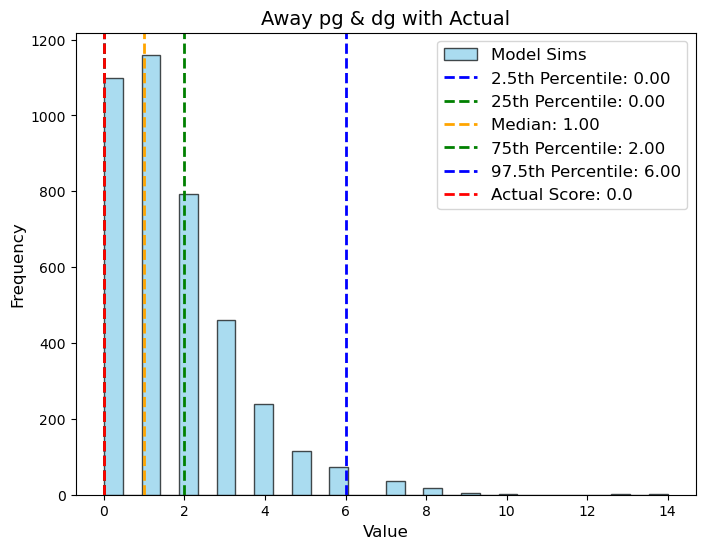

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# run a loop to run through scores
i = 0

# set data
sim_data = away_pg_dg_sim[i].values

# Calculate 95% percentiles
lower_percentile = np.percentile(sim_data, 2.5)
upper_percentile = np.percentile(sim_data, 97.5)
lower_25 = np.percentile(sim_data, 25)
upper_75 = np.percentile(sim_data, 75)
median = np.percentile(sim_data, 50)


# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(sim_data, bins=30, color='skyblue',
         alpha=0.7, edgecolor='black', label='Model Sims')

# Add vertical lines for the percentiles
plt.axvline(lower_percentile, color='blue', linestyle='--', linewidth=2, label=f'2.5th Percentile: {lower_percentile:.2f}')
plt.axvline(lower_25, color='green', linestyle='--', linewidth=2, label=f'25th Percentile: {lower_25:.2f}')
plt.axvline(median, color='orange', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
plt.axvline(upper_75, color='green', linestyle='--', linewidth=2, label=f'75th Percentile: {upper_75:.2f}')
plt.axvline(upper_percentile, color='blue', linestyle='--', linewidth=2, label=f'97.5th Percentile: {upper_percentile:.2f}')


# Add a vertical line
plt.axvline(test_data_sample.Away_pg_dg.iloc[i],
            color='red', linestyle='--', linewidth=2, 
            label=f'Actual Score: {test_data_sample.Away_pg_dg.iloc[i]}')

# Add labels, title, and legend
plt.title('Away pg & dg with Actual', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)

# Show the plot
plt.show()


In [148]:
# Graph Model
# I think sigma away points should be in the atts box
# Generate the graph
graph = pm.model_to_graphviz(nb_model)

# Save the graph as an image
graph.render("nb_model_graph", format="png", cleanup=True)

'nb_model_graph.png'

<Axes: >

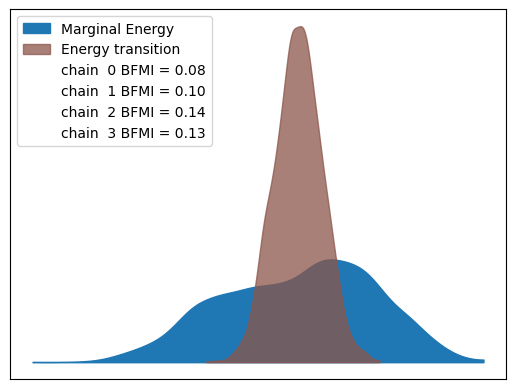

In [145]:
# Unsure what this plot is
# Distributions are not similar so must be something wrong
# This seems the best one so far
az.plot_energy(trace)

array([[<Axes: title={'center': 'atts_mu_tries'}>,
        <Axes: title={'center': 'atts_mu_tries'}>]], dtype=object)

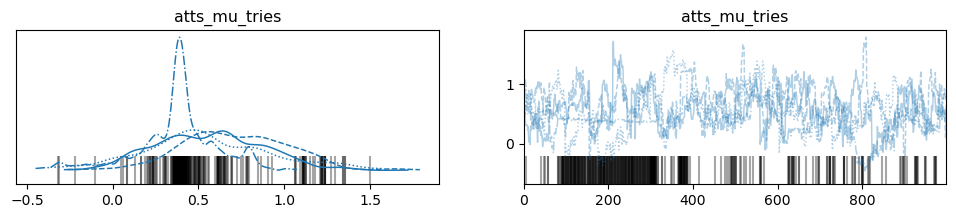

In [146]:
# Plot doesn't look like it has converged
az.plot_trace(trace, var_names=["atts_mu_tries"])

In [22]:
home_data = posterior_predictive_samples.posterior_predictive['home_score_model']

# Initialize a list to store results
home_results = []

for i in range(57):
    p2_5 = np.percentile(home_data[:,:,i], 2.5)
    p16 = np.percentile(home_data[:,:,i], 16)
    p25 = np.percentile(home_data[:,:,i], 25)
    p50 = np.percentile(home_data[:,:,i], 50)
    mean = np.mean(home_data[:,:,i]).values
    std = np.std(home_data[:,:,i]).values
    p75 = np.percentile(home_data[:,:,i], 75)
    p84 = np.percentile(home_data[:,:,i], 84)
    p97_5 = np.percentile(home_data[:,:,i], 97.5)

    # Append the results as a dictionary
    home_results.append({"p2_5":p2_5,"p16":p16,"p25":p25,"p50":p50, "Mean": mean,"std":std, "p75": p75, "p84": p84,"p97_5": p97_5})
    

# Convert the results to a DataFrame
home_points_df = pd.DataFrame(home_results)

In [23]:
away_data = posterior_predictive_samples.posterior_predictive['away_score_model']

# Initialize a list to store results
away_results = []

for i in range(57):
    p2_5 = np.percentile(away_data[:,:,i], 2.5)
    p16 = np.percentile(away_data[:,:,i], 16)
    p25 = np.percentile(away_data[:,:,i], 25)
    p50 = np.percentile(away_data[:,:,i], 50)
    mean = np.mean(away_data[:,:,i]).values
    std = np.std(away_data[:,:,i]).values
    p75 = np.percentile(away_data[:,:,i], 75)
    p84 = np.percentile(away_data[:,:,i], 84)
    p97_5 = np.percentile(away_data[:,:,i], 97.5)

    # Append the results as a dictionary
    away_results.append({"p2_5":p2_5,"p16":p16,"p25":p25,"p50":p50, "Mean": mean,"std":std, "p75": p75, "p84": p84,"p97_5": p97_5})
    

# Convert the results to a DataFrame
away_points_df = pd.DataFrame(away_results)

In [24]:
# Combine chain and draw data into 1 sample and round to integers
away_draw_chains =  az.extract(away_data).away_score_model.values
home_draw_chains = az.extract(home_data).home_score_model.values

# Perform element-wise comparisons for all columns
home_win = np.sum(home_draw_chains > away_draw_chains, axis=1) 
away_win = np.sum(home_draw_chains < away_draw_chains, axis=1)  
draw = np.sum(home_draw_chains == away_draw_chains, axis=1)  

# Calculate percentages
total_comparisons = home_draw_chains.shape[1]
percent_home_win = (home_win / total_comparisons) * 100
percent_away_win = (away_win / total_comparisons) * 100
percent_draw = (draw / total_comparisons) * 100

# Create a summary DataFrame
summary_stats = pd.DataFrame({
    "Home Win (%)": percent_home_win,
    "Away Win (%)": percent_away_win,
    "Draw (%)": percent_draw,
})

# Display the summary DataFrame
#print(summary_stats)


In [27]:

# Merge actual back to sim for home
join_home = pd.merge(home_points_df,train_data[['home_team','home_score']],left_index=True, right_index=True)

join_home['Mean'] = join_home['Mean'].astype(float)

# Round to 2 decimal places
join_home = join_home.round(2)

# create flag columns
join_home['95_flag'] = join_home.apply(lambda row: 1 if row['p2_5'] <= row['home_score'] <= row['p97_5'] else 0,axis=1)
join_home['68_flag'] = join_home.apply(lambda row: 1 if row['p16'] <= row['home_score'] <= row['p84'] else 0,axis=1)
join_home['50_flag'] = join_home.apply(lambda row: 1 if row['p25'] <= row['home_score'] <= row['p75'] else 0,axis=1)


# Select new columns
join_home = join_home[['home_team','home_score','Mean','std','95_flag','68_flag','50_flag']]

# Get rates
print('95% rate: ',round(join_home['95_flag'].sum()/join_home['95_flag'].count(),2))
print('68% rate: ',round(join_home['68_flag'].sum()/join_home['68_flag'].count(),2))
print('50% rate: ',round(join_home['50_flag'].sum()/join_home['50_flag'].count(),2))


# Merge actual back to sim for away
join_away = pd.merge(away_points_df, train_data[['away_team','away_score']],left_index=True, right_index=True)

join_away['Mean'] = join_away['Mean'].astype(float)

# Round to 2 decimal places
join_away = join_away.round(2)


# create flag columns
join_away['95_flag'] = join_away.apply(lambda row: 1 if row['p2_5'] <= row['away_score'] <= row['p97_5'] else 0,axis=1)
join_away['68_flag'] = join_away.apply(lambda row: 1 if row['p16'] <= row['away_score'] <= row['p84'] else 0,axis=1)
join_away['50_flag'] = join_away.apply(lambda row: 1 if row['p25'] <= row['away_score'] <= row['p75'] else 0,axis=1)

# Select new columns
join_away = join_away[['away_team','away_score','Mean','std','95_flag','68_flag','50_flag']]

# Get rates
print('95% rate: ',round(join_away['95_flag'].sum()/join_away['95_flag'].count(),2))
print('68% rate: ',round(join_away['68_flag'].sum()/join_away['68_flag'].count(),2))
print('50% rate: ',round(join_away['50_flag'].sum()/join_away['50_flag'].count(),2))


# Merge actual back to sim for away
join_all_flags = pd.merge(join_home, join_away,left_index=True, right_index=True)

join_all_flags = join_all_flags[['home_team', 'home_score', 
                                 'away_team', 'away_score',
                                 'Mean_x','std_x', '95_flag_x', '68_flag_x',
       '50_flag_x',  'Mean_y','std_y', '95_flag_y',
       '68_flag_y', '50_flag_y']]

# calculate residuals
# Originally avg 8.66 home, 10.66 away
# New model slightly better 8.55 home and 10.65 away
# Down to 7.78 and 9.8 - could be the sim

join_all_flags['home_resid'] = join_all_flags['home_score'] - join_all_flags['Mean_x']
join_all_flags['away_resid'] = join_all_flags['away_score'] - join_all_flags['Mean_y']

# Create absolute column
join_all_flags['home_resid_abs'] = join_all_flags['home_resid'].abs()
join_all_flags['away_resid_abs'] = join_all_flags['away_resid'].abs()

home_rmse = np.sqrt(np.mean((join_all_flags['home_resid']) ** 2))
away_rmse = np.sqrt(np.mean((join_all_flags['away_resid']) ** 2))

print('home_rmse: ',home_rmse)
print('away_rmse: ',away_rmse)

# Originally 39%, this increased to 41%
# R squared also increased to 51%
from sklearn.metrics import r2_score

# Compare observed and predicted data
r2 = r2_score(join_all_flags['home_score'].values, join_all_flags['Mean_x'].values)
print(f"R-squared: {r2}")

# Join summary stats
join_percentages = pd.merge(join_all_flags,summary_stats,left_index=True,right_index=True)




95% rate:  1.0
68% rate:  1.0
50% rate:  0.78
95% rate:  0.89
68% rate:  0.78
50% rate:  0.67
home_rmse:  10.31359243372012
away_rmse:  13.821008967831867
R-squared: -0.8215613742071883


In [28]:
# This is good for analysing residuals and seeing where prediction went wrong
# Think sd for all teams is too restrictive
join_percentages.to_csv('join_percentages_nb.csv')

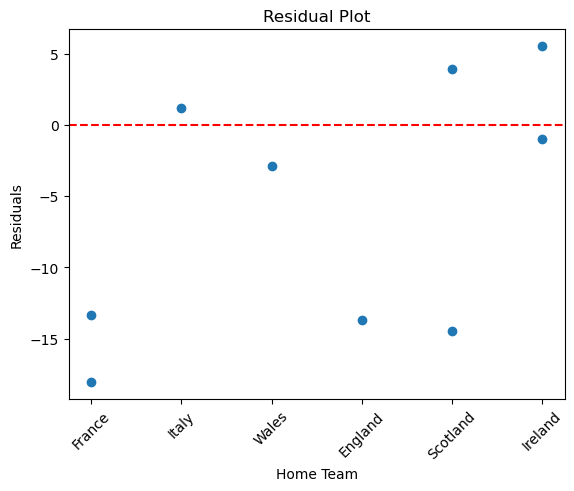

In [29]:
# Plot residuals for home score
import matplotlib.pyplot as plt

plt.scatter(join_all_flags['home_team'], join_all_flags['home_resid'].values)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Home Team")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.xticks(rotation=45)
plt.show()